# Importing

In [14]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.optimizers import Adam
from keras.models import *
from keras.layers import *
from tensorflow.keras.preprocessing.image import  img_to_array, load_img

import numpy as np
from numpy import *


BATCH_SIZE = 32
SEED_SIZE =100
WIDTH = 64
HEIGHT = 64
channels = 3

# preprocessing the data

In [2]:
def process_image(path, height, width):
    img = load_img(path, target_size = (height, width))
    img = (img_to_array(img)-127.5)/127.5
    return img

In [3]:
dataset_path = "/kaggle/input/best-artworks-of-all-time/resized/resized"

images = []
for path in os.listdir(dataset_path):
    images.append(process_image(dataset_path+"/" +path, 64,64))
    
images = np.array(images)

In [4]:
np.random.shuffle(images)
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(1000).batch(BATCH_SIZE)

# Plotting the images

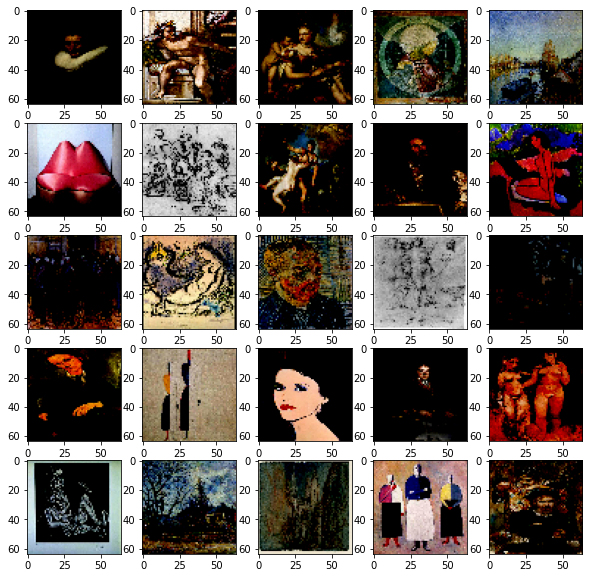

In [5]:
fig = plt.figure(figsize=(10,10))
for i in range(1,26):
    fig.add_subplot(5,5,i)
    plt.imshow(images[i])
plt.show()

# Building models

Genarator

In [34]:
def generation_model(size, channels):
    
    model = Sequential()
    model.add(Dense(4096 , activation="relu" , input_dim=size))
    model.add(Reshape((4,4,256)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D(size = (2,2)))
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))
    
    return model

Discriminator

In [35]:
def discrimination_model(shape):
    
    model = Sequential()

    model.add(Conv2D(16, kernel_size=3, strides=2, input_shape =shape, padding="same"))
    model.add(LeakyReLU(alpha=1/5))
    
    model.add(Dropout(1/4))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=1/5))

    model.add(Dropout(1/4))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=1/5))

    model.add(Dropout(1/4))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=1/5))

    model.add(Dropout(1/4))
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=1/5))

    model.add(Dropout(0.2))
    model.add(Conv2D(512, kernel_size=3, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=1/5))

    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [36]:
generator= generation_model(SEED_SIZE,channels)
discriminator =discrimination_model((HEIGHT, WIDTH, channels))

# Calculating losses

In [37]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(realoutput, fakeoutput):
    real = cross_entropy(tf.ones_like(realoutput), realoutput)
    fake = cross_entropy(tf.zeros_like(fakeoutput), fakeoutput)
    totalloss = real + fake
    return totalloss

def generator_loss(fakeoutput):
    return cross_entropy(tf.ones_like(fakeoutput), fakeoutput)



In [38]:
generator_optimizer = tf.keras.optimizers.Adam(1.2e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)

# Training both the models


In [39]:
def train(dataset, epochs):
    
    for epoch in range(1,epochs+1):
        gen_loss_list = []
        disc_loss_list = []
        
        for images in dataset:
            seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = generator(seed, training = True)

                real_output = discriminator(images, training=True)
                fake_output = discriminator(generated_images, training=True)
                gen_loss = generator_loss(fake_output)
                dis_loss = discriminator_loss(real_output, fake_output)

                gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
                gradients_of_discriminator = disc_tape.gradient(dis_loss,discriminator.trainable_variables)

                generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
                discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            gen_loss_list.append(gen_loss)
            disc_loss_list.append(dis_loss)
        
        print("Epoch :", epoch, "   generation loss : " , sum(gen_loss_list) / len(gen_loss_list) , "    discrimination loss : ", sum(disc_loss_list) / len(disc_loss_list))

In [42]:
train(dataset, 250)

Epoch : 1    generation loss :  1.9033674352309282     discrimination loss :  1.04296875
Epoch : 2    generation loss :  0.8907166649313534     discrimination loss :  1.4160913579604204
Epoch : 3    generation loss :  0.7865617976469153     discrimination loss :  1.4480188033160042
Epoch : 4    generation loss :  0.7502693849451402     discrimination loss :  1.4486000958610983
Epoch : 5    generation loss :  0.7590839161592371     discrimination loss :  1.4245331708122702


# Final Art generator

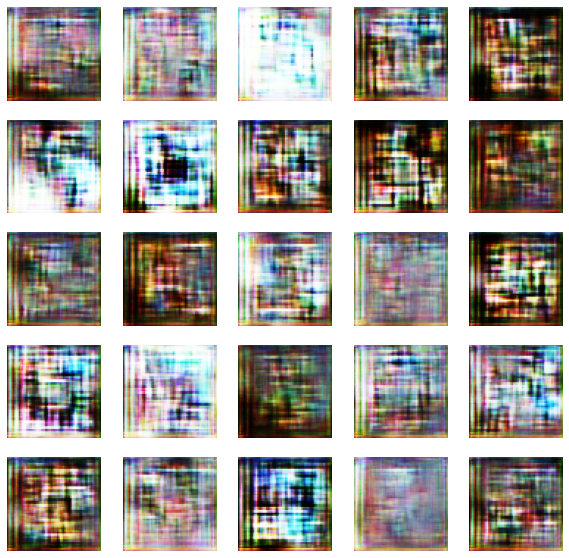

In [45]:
seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])
gen_imgs = generator(seed, training = True)
gen_imgs = gen_imgs/2 + (1/2)
fig = plt.figure(figsize=(10,10))

for i in range(1,26):
    fig.add_subplot(5,5,i)
    plt.imshow(gen_imgs[i])
    plt.axis('off')
plt.show()